# Prediction NBA Points Per Game For First Round Draft Picks

- CPSC 310, Spring 2019
- Names: Reid Whitson and Luc Latiolait

## Introduction

Our goal for this project is to create a program which will guess how many points per game a first round pick will have in the NBA. To achieve this goal, we will first gather data, then we will explore some classifiers and lastly we will compare our home made algorithm versus whichever sci-kit learn classifier did best and compare the answers. We found that KNN was the best classifier for the data and therefore have implemented our own classifier at the end to compare how they worked.

## Data Analysis

The data set we gathered were players picked in their first round along with their NBA ppg and College Stats. To find the corresponding first Round picks stats from college we had to search the players one by one and append them onto the set. 

As the game has changed over the years, so has players and how they perform. We don't want to be basing our predictions off of statistics from the 50's. The significance of the data lessens every year, so we chose to focus on the last 10 years.

The attributes that we chose as important attributes were
1. The pick they were chosen at
1. Minutes played
1. Field Goals
1. Field Goal Percentage
1. Three Points
1. Three Point Percentage
1. Free Throws
1. Points
1. Strength of Schedule

In [22]:
import operator
import random
import math
import numpy as np
import utils

def get_table(filename):
    table = []
    infile = open(filename)
    lines = infile.readlines()
    
    i = 0
    for line in lines:
        add_it = True
        line = line.strip()
        line = line.strip('\n')
        values = line.split(",")
       
        #this is only grabbing columns that are completely filled in
        if len(values) > 27:        
            for val in values:
                #Get rid of columns with NA in them
                if val == 'NA':
                    add_it = False
            if add_it: 
                '''
                player - 6, pick - 4, MP - 31
                FG - 32 , FG% - 34, 3p - 38
                3pt% - 40, FT - 41, PTS - 52
                SOS - 54, NBA PTS - 15
                '''
                
                to_add = []
                to_add.append(values[6])
                to_add.append(values[4])
                to_add.append(values[31])
                to_add.append(values[32])
                to_add.append(values[34])
                to_add.append(values[38])
                if values[40] == '':
                    to_add.append(0.0)
                else:
                    to_add.append(values[40])
                to_add.append(values[41])
                to_add.append(values[52])
                to_add.append(values[54])
                to_add.append(values[15])
                utils.convert_to_numeric(to_add)
                table.append(to_add)
    infile.close()
    return table

# Exploratory Analysis of the Data Set

The first step we took in working with our data set was to analyze the distribution of our attributes. As shown by the graphs below, most of the attributes have a normal distribution, but some do not. For some of the attributes this outcome should be expected, such as pick number, which should be evenly distributed; However, minutes played and 3 pointers per game stand out as abnormal. One explanation for the way minutes played clusters to the right could be that that there is a maximum limit (40 minutes) that players can reach per game. As for the 3 pointers per game graph, there seems to be two peaks in the histogram, which could indicate that there are two distributions of players, those that attempt many 3s per game (shooters), and those that do not (non-shooters). Also, NBA points per game seems to cluster to the left, which is understandable, given that even players drafted in the first round often play very little, if ever, in the NBA.

<IPython.core.display.Javascript object>


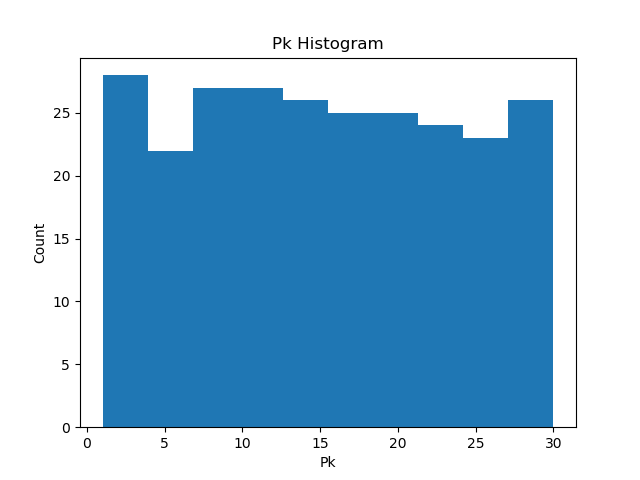

<IPython.core.display.Javascript object>


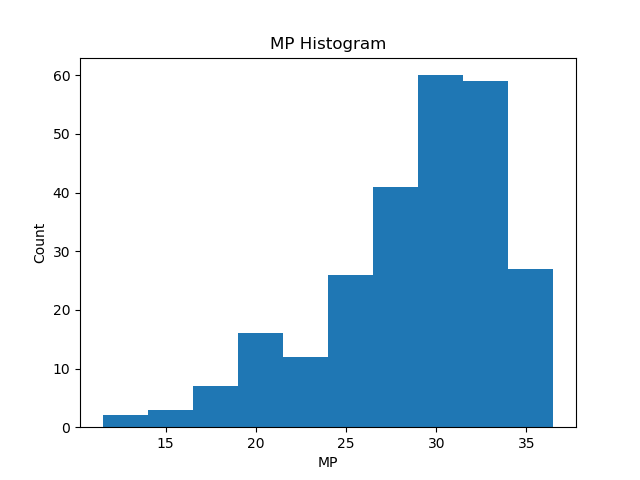

<IPython.core.display.Javascript object>


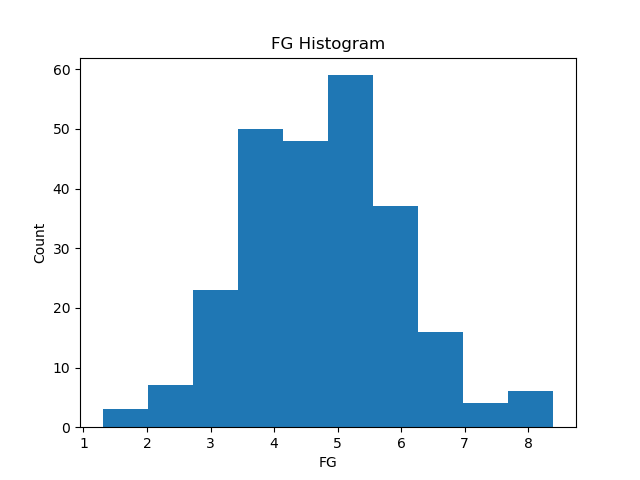

<IPython.core.display.Javascript object>


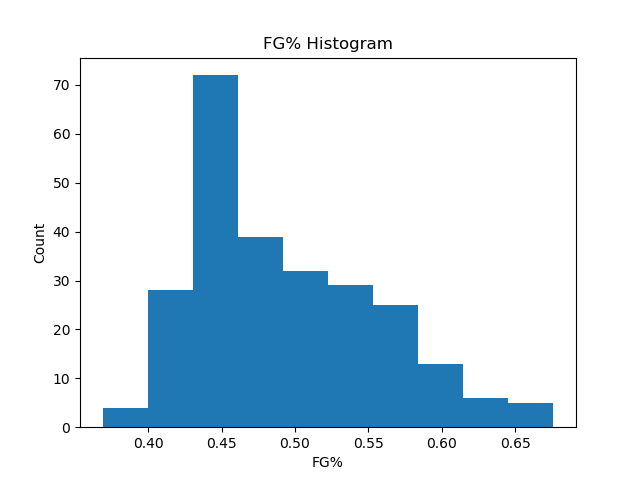

<IPython.core.display.Javascript object>


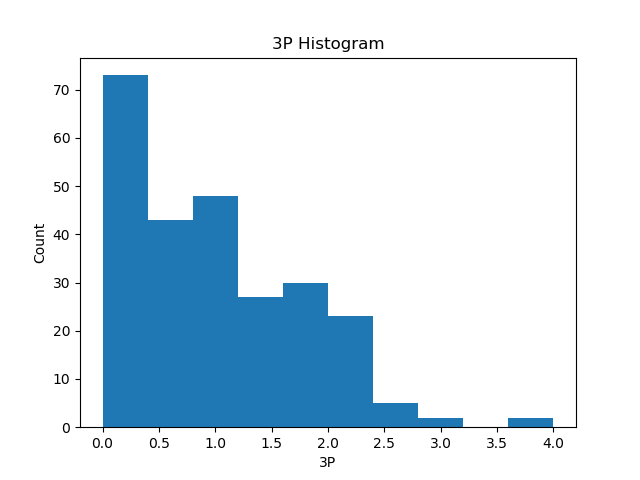

<IPython.core.display.Javascript object>


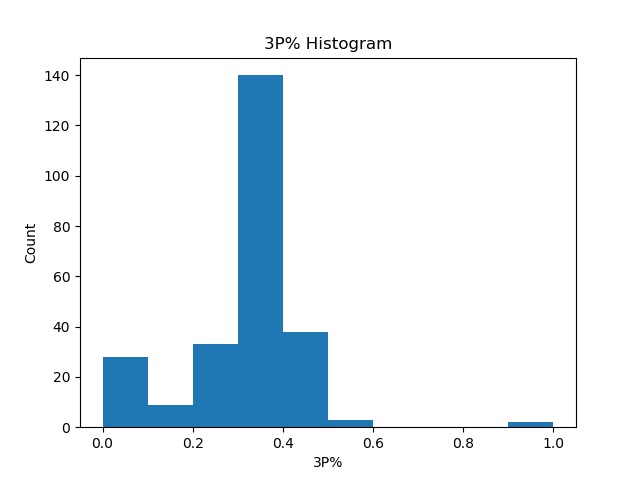

<IPython.core.display.Javascript object>


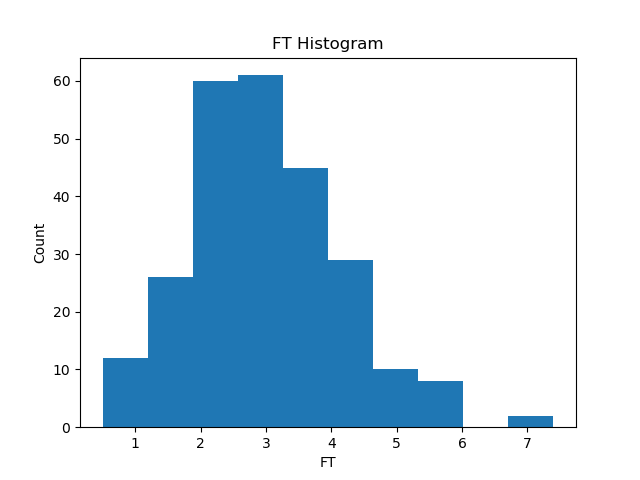

<IPython.core.display.Javascript object>


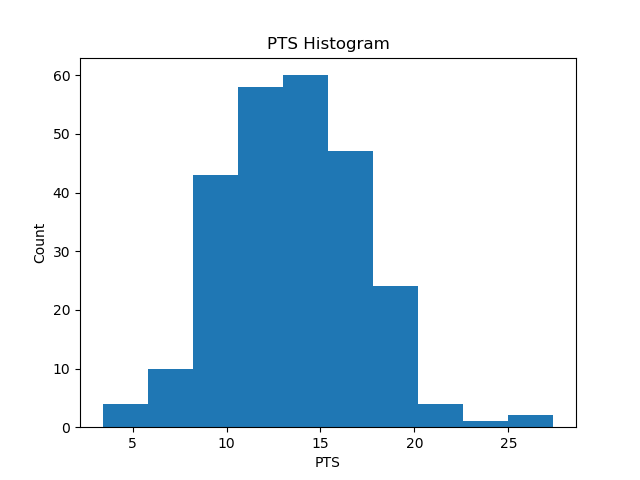

<IPython.core.display.Javascript object>


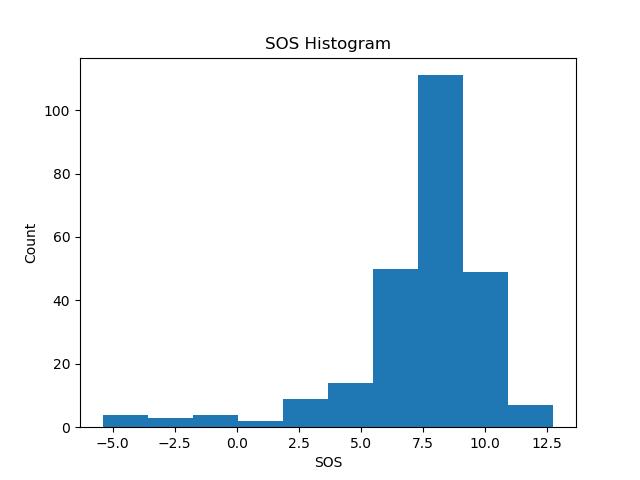

<IPython.core.display.Javascript object>


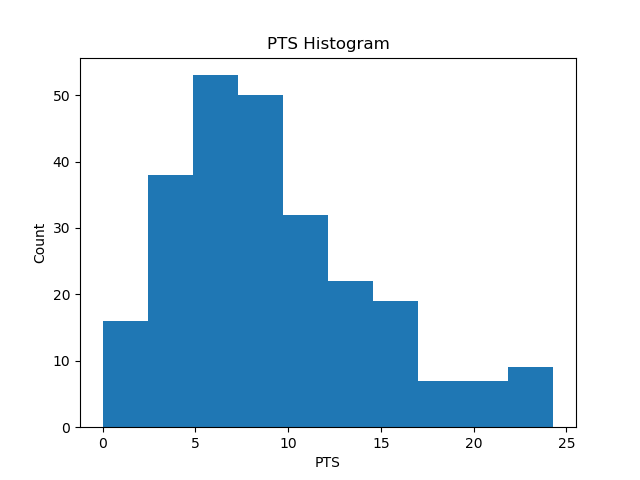

In [23]:
%matplotlib notebook
import operator
import random
import math
import numpy as np
import utils
import matplotlib.pyplot as plt 


def attribute_histograms(table, headers):
    for i in range(1, len(headers)):
        col = utils.get_column(table, i)
        header = headers[i]
        show_histogram(col, header)
        
def show_histogram(column, header):
    '''
    makes a histogram using the passed in data
    '''
    fig = plt.figure()
    plt.hist(column)
    plt.xlabel(header)
    plt.ylabel("Count")
    plt.title( header +' Histogram')
    plt.show
    
start_table = get_table('firstRoundPicks_withCollegeStats.csv')
headers = start_table[0]
table = start_table[1:]
attribute_histograms(table, headers)
    

# Exploratory Classifiers

Here we focus on the exploratory process of looking at different learners and how they perform. We chose to use KNN, linear regression and Naive Bayes. For Naive Bayes we had to discretize the amount of points, 0-5, 5-10, 10-15, 15-20 and greater than 20. Therefore, the amount that it is off is by its classification and not complete points. 

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB

ensemble_size = 6

list_of_ind = [i for i in range(1,10)]
player_pred_knn = [0 for _ in range(len(table))]
player_pred_lin = [0 for _ in range(len(table))]
player_pred_NB = [0 for _ in range(len(table))]
Y = [row[10] for row in table]
Y_d = []

for row in table:
    if row[10] < 5:
        Y_d.append(1)
    elif row[10] < 10:
        Y_d.append(2)
    elif row[10] < 15:
        Y_d.append(3)
    elif row[10] < 20:
        Y_d.append(4)
    else:
        Y_d.append(5)

for _ in range(ensemble_size):
    X = []
    #randomly generate 4 numbers to be included
    attributes = list_of_ind
    random.shuffle(attributes)
    attributes = attributes[:4]

    for row in table:
        inter = []
        for i in attributes:
            inter.append(row[i])
        X.append(inter)

    #knn model
    n = KNeighborsRegressor(n_neighbors=5)
    n.fit(X,Y)
    
    #linear-reg model
    l = LinearRegression().fit(X,Y)
    
    #Gaussian Naive Bayes
    g = GaussianNB()
    g.fit(X,Y_d)
    
    for i, player in enumerate(table):
        #get predictions for each classifier
        rows_to_analyze = [player[a] for a in attributes]
        player_pred_knn[i] += (n.predict([rows_to_analyze]))[0]
        player_pred_lin[i] += (l.predict([rows_to_analyze]))[0]
        player_pred_NB[i] += (g.predict([rows_to_analyze]))[0]

#keep track of the final predictions for each
final_pred_knn = [pred / ensemble_size for pred in player_pred_knn]
final_pred_lin = [pred / ensemble_size for pred in player_pred_lin]
final_pred_NB = [pred / ensemble_size for pred in player_pred_NB]

total_error_knn = 0
total_error_lin = 0
total_error_NB = 0

#get the final error
for i,player in enumerate(table):
    total_error_knn += abs(final_pred_knn[i] - player[10])
    total_error_lin += abs(final_pred_lin[i] - player[10])
    total_error_NB += abs(final_pred_NB[i] - Y_d[10])

print("---------------------------------")
print("Total points off for sci-kit learn-KNN: %.2f" % (total_error_knn / len(table)))
print("Total points off for sci-kit learn-LinReg: %.2f" % (total_error_lin / len(table)))
print("Total points off for sci-kit learn-NB: %.2f" % (total_error_NB / len(table)))


---------------------------------
Total points off for sci-kit learn-KNN: 3.15
Total points off for sci-kit learn-LinReg: 3.72
Total points off for sci-kit learn-NB: 0.53


The above answer for Naive Bayes is based on classifications 1 to 5 which is based on different 5 points baskets. Therefore we want this to be very low for it to be considered successful. 

# Home-Made KNN function


In the knn_guess function we take in the training set and the test set and find its nearest neighbors, compute the average points of the nearest neighbors and returns that value.

In [26]:
def knn_guess(train_set, test_set, k_val):
    '''
    classifier using knn given a test set, train set and k value
    '''
    
    init_len = len(train_set)
    init_row_len = len(train_set[0])
    
    right = 0
    wrong = 0

    for row in train_set:
        row.append(utils.compute_distances(row, test_set, train_set))  

    k = k_val
    
    length_of_rows = len(train_set[0])
    train_set.sort(key=operator.itemgetter(length_of_rows-1))

    top_k = train_set[:k]

    # calculate the averages from the nearest neighbors
    sum_ppg = 0
    for player in top_k:
        sum_ppg += player[init_row_len-1]
    avg_ppg = sum_ppg/len(top_k)

    for row in train_set:
        row.pop()
    
    return avg_ppg

knnPrediction runs over each guess and adds them to a list to be computed. After we get the guess, we then compute the average error and median and add it to a list to compute the total average later.

In [27]:
def knnPrediction(table, headers, avg_error, median_error):    
    folds = utils.k_fold(table)
    differences = []
    for i in range(len(folds)):
        train_set = []
        
        #get the train set
        for x in folds:
            if x != folds[i]:
                for item in x:
                    train_set.append(item)
                    
        #compute the guess
        for j in folds[i]:
            my_guess = knn_guess(train_set, j, 10)
            diff = j[-1] - my_guess
            differences.append(abs(diff))

    avg_error.append(np.mean(differences))
    median_error.append(np.median(differences))
            

First we run our kNN functions with all 9 attributes to test its effectiveness. In order to reduce the effects of random k-fold cross validation.

In [28]:
avg_error = []
median_error = []

#run it ten times and keep track of errors
for _ in range(10):
    knnPrediction(table, headers, avg_error, median_error)
    
total_avg_error = sum(avg_error) / len(avg_error)
total_median_error = sum(median_error) / len(median_error)

print("---------SELF MADE KNN----------")
print("Average error : %.2f" % total_avg_error)
print("Median error : %.2f" % total_median_error)

---------SELF MADE KNN----------
Average error : 3.72
Median error : 2.98


Here we randomly generate the attributes to include, and then run the predictor over it. This is part of our ensemble technique to get the best values we can.

In [29]:
ensemble_size = 6

list_of_ind = [i for i in range(1,10)]

avg_error = []
median_error = []

#run it for each one of our ensembles.
for _ in range(ensemble_size):
    X = []
    attributes = list_of_ind
    random.shuffle(attributes)
    attributes = attributes[:4]

    #run it over the current table
    for row in table:
        inter = []
        for i in attributes:
            inter.append(row[i])
        inter.append(row[-1])
        X.append(inter)
    
    knnPrediction(X, headers, avg_error, median_error)

#get the total error and median error
total_avg_error = sum(avg_error) / len(avg_error)
total_median_error = sum(median_error) / len(median_error)

print("---------SELF MADE ENSEMBLE KNN----------")
print("Average error : %.2f" % total_avg_error)
print("Median error : %.2f" % total_median_error)

---------SELF MADE ENSEMBLE KNN----------
Average error : 4.16
Median error : 3.56


### Function for Correlation Coefficients

In [30]:
def find_stat_correlation_to_NBA_PTS(table, headers):
    NBA_PTS = utils.get_column(table, 10)
    for i in range(1, len(headers)-1):
        cur_column = utils.get_column(table, i)
        vals = np.corrcoef(cur_column, NBA_PTS)
        r = str(vals[0][-1])
        print (headers[i] + " correlation coefficent = " + r)

find_stat_correlation_to_NBA_PTS(table, headers)

Pk correlation coefficent = -0.5299465872708524
MP correlation coefficent = 0.1749833043310192
FG correlation coefficent = 0.29527019590799053
FG% correlation coefficent = 0.015356915756806793
3P correlation coefficent = 0.13359012899775405
3P% correlation coefficent = 0.014105221082955912
FT correlation coefficent = 0.32641009023623113
PTS correlation coefficent = 0.33481771379868946
SOS correlation coefficent = 0.005506932566690757


## Predicting Scoring for 2019 Draft Prospects

After testing the preformance of our kNN classifiers, we decided to enter a few of the top prospects for the 2019 NBA draft to see what their predicted NBA points per game would be.

First we ran the predictor with all attributes:

In [31]:
players = [["Zion Williamson",1, 30.0,9.0,0.680,0.7,.338,3.9,22.6,11.97,"NA"],
           ["R.J. Barret",2,35.3,8.4,.454,1.9,.308,3.9,22.6,11.97,"NA"],
           ["Ja Morant",3,35.3,6.1,.485,1.3,.343,5.1,18.7,-3.32,"NA"],
           ["Rui Hachimura",11,30.2,7.4,.591,0.4,.417,4.4,19.7,5.01,"NA"],
           ["Brandon Clarke",8,28.1,6.9,.687,0.1,.267,2.9,16.9,5.01,"NA"]
          ]

for row in players:
    print (row[0] + ": " + str(knn_guess(table, row, 5)))

Zion Williamson: 14.86
R.J. Barret: 13.580000000000002
Ja Morant: 15.66
Rui Hachimura: 13.1
Brandon Clarke: 11.799999999999999


Then, we ran the predictor with only the 5 attributes with the highest correlation coefficient.

In [32]:
players_2= [["Zion Williamson", 30.0,9.0,3.9,22.6,11.97,"NA"],
           ["R.J. Barret",35.3,8.4,3.9,22.6,11.97,"NA"],
           ["Ja Morant",35.3,6.1,5.1,18.7,-3.32,"NA"],
           ["Rui Hachimura",30.2,7.4,4.4,19.7,5.01,"NA"],
           ["Brandon Clarke",28.1,6.9,2.9,16.9,5.01,"NA"]
          ]

picked_atts_table = []
atts = [0,2,3,7,8,9,10]

#get each attribute that had best performance
for row in table:
    temp = []
    for att in atts:
        temp.append(row[att])
    picked_atts_table.append(temp)
    
#predict
for row in players_2:
    print (row[0] + ": " + str(knn_guess(picked_atts_table, row, 5)))

Zion Williamson: 11.360000000000001
R.J. Barret: 12.3
Ja Morant: 11.98
Rui Hachimura: 13.419999999999998
Brandon Clarke: 9.58


## Prediction 2019 picks using Sklearn

In [33]:
players = [["Zion Williamson",1, 30.0,9.0,0.680,0.7,.338,3.9,22.6,11.97,"NA"],
           ["R.J. Barret",2,35.3,8.4,.454,1.9,.308,3.9,22.6,11.97,"NA"],
           ["Ja Morant",3,35.3,6.1,.485,1.3,.343,5.1,18.7,-3.32,"NA"],
           ["Rui Hachimura",11,30.2,7.4,.591,0.4,.417,4.4,19.7,5.01,"NA"],
           ["Brandon Clarke",8,28.1,6.9,.687,0.1,.267,2.9,16.9,5.01,"NA"]
          ]
X = [row[1:-2] for row in table]
y = [row[-1] for row in table]

#create model
kn = KNeighborsRegressor(n_neighbors=5)
kn.fit(X,y)

#predict
for player in players:
    print((player[0] + ": " + str(kn.predict([player[1:-2]])[0])))

Zion Williamson: 15.14
R.J. Barret: 15.88
Ja Morant: 17.18
Rui Hachimura: 7.62
Brandon Clarke: 10.58


As we can see, there are some big differences between our classifier versus the sci-kit learn classifier. Choose wisely!

## Classification Results

We measured the performance of our classifiers with its average error. To compute this, we took the absolute value of the difference between the predicted NBA points per game of a player and their actual NBA points per game. According to this measure, our best classifier was the sci-kit learn kNN classifier, with an average error of 3.15 ppg. The rest of the classifiers we used had fairly similar performance with the sci-kit learn regression classifier having an average error of 3.72 ppg, our self made kNN returning an average error of 3.72 ppg, and our self made ensemble kNN outputting an average error of 4.16 ppg. In assessing our self made kNN classifiers, it appears that they struggled to make accurate predictions for outliers, because both have much better median error than average error. 

In addition, our kNN predictor with all 9 attributes performed meaningfully better than our ensemble predictor despite the inclusion of several noisy attributes. This is likely because our ensemble kNN classifier selects attributes randomly, likely increasing the effects of noisy attributes when they are selected. Overall, all of our classifiers performed better than expected given the large amount of variance in our data set. Any classifier that can consistently predict the scoring output of an NBA prospect within a range of 3 to 4 ppg is a very useful tool for draft analysts and scouts.

# Conclusion


Through our exploration of classifiers and comparison with sci-kit learn we found that KNN is the best, and that the sci-kit learn was about a point closer on average. The hardest part of this project was dealing with finding and cleaning the data, this was due to the fact that the data for college stats wasn't easily available so we had to get the data one row at a time. There was also some cases when college stats didn't make sense (such as players who don't have college stats) which we had to clean out of our data set. I believe that KNN was a good approach to this problem due to the fact of looking at players that are similar usually provides decent results. For ways to help with performance, we could looked a little bit more specifically at the correlation coefficient and chose ones that only showed good correlation.